In [258]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.models import *

In [259]:
data = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,TNX.Low,TNX.Close,TNX.Volume,TNX.Adjusted,RYSDX.Open,RYSDX.High,RYSDX.Low,RYSDX.Close,RYSDX.Volume,RYSDX.Adjusted
3095,2019-04-22,186.570007,187.990005,186.429993,187.919998,17936000,187.919998,269.000000,269.679993,262.480011,...,1.14,1.23,47944,1.23,52.619999,52.619999,52.619999,52.619999,0,52.619999
3096,2019-04-23,188.399994,190.539993,188.130005,190.309998,33665600,190.309998,260.149994,265.600006,255.750000,...,1.19,1.19,16650,1.19,52.950001,52.950001,52.950001,52.950001,0,52.950001
3097,2019-04-24,190.470001,190.710007,189.649994,189.710007,24977100,189.710007,263.850006,265.320007,258.000000,...,1.13,1.19,30603,1.19,53.509998,53.509998,53.509998,53.509998,0,53.509998
3098,2019-04-25,191.130005,191.220001,189.449997,190.479996,29517500,190.479996,255.000000,259.000000,246.070007,...,1.12,1.15,9100,1.15,53.660000,53.660000,53.660000,53.660000,0,53.660000
3099,2019-04-26,190.179993,190.690002,188.589996,190.649994,26359500,190.649994,246.500000,246.679993,231.130005,...,1.13,1.15,12270,1.15,53.490002,53.490002,53.490002,53.490002,0,53.490002


In [260]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data.columns)) if 'Open' in i[1]])
ticker_lookup

{'AAPL': 25,
 'AMD': 67,
 'AMZN': 37,
 'DATA': 61,
 'DIS': 145,
 'DUK': 157,
 'FB': 43,
 'GLD': 175,
 'HD': 151,
 'INTC': 19,
 'JNJ': 103,
 'JWN': 91,
 'KO': 109,
 'MSFT': 13,
 'NFLX': 31,
 'NVDA': 127,
 'PANW': 121,
 'PG': 97,
 'QQQ': 1,
 'RHT': 133,
 'RYSDX': 193,
 'SBUX': 73,
 'SLV': 181,
 'SPOT': 163,
 'SQ': 49,
 'TGT': 85,
 'TNX': 187,
 'TSLA': 7,
 'TWTR': 55,
 'USO': 139,
 'VRSN': 115,
 'WDC': 169,
 'WMT': 79}

In [261]:
CHOSENTICKER = 'JNJ'

In [262]:
# This works for next hypothesis
theta = 0.01
# pct_df = data.iloc[:,1:].pct_change(1) # all columns
# data = pct_df[pct_df > theta].fillna(0).apply(lambda x: [1 if y > 0 else 0 for y in x])
pct_df = data.iloc[:,ticker_lookup[CHOSENTICKER]].pct_change(1).fillna(0).apply(lambda y: 1 if y > 0 else 0) # 1 columns
data["tick_pct_change"] = pct_df
data.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,TNX.Close,TNX.Volume,TNX.Adjusted,RYSDX.Open,RYSDX.High,RYSDX.Low,RYSDX.Close,RYSDX.Volume,RYSDX.Adjusted,tick_pct_change
3095,2019-04-22,186.570007,187.990005,186.429993,187.919998,17936000,187.919998,269.000000,269.679993,262.480011,...,1.23,47944,1.23,52.619999,52.619999,52.619999,52.619999,0,52.619999,0
3096,2019-04-23,188.399994,190.539993,188.130005,190.309998,33665600,190.309998,260.149994,265.600006,255.750000,...,1.19,16650,1.19,52.950001,52.950001,52.950001,52.950001,0,52.950001,1
3097,2019-04-24,190.470001,190.710007,189.649994,189.710007,24977100,189.710007,263.850006,265.320007,258.000000,...,1.19,30603,1.19,53.509998,53.509998,53.509998,53.509998,0,53.509998,1
3098,2019-04-25,191.130005,191.220001,189.449997,190.479996,29517500,190.479996,255.000000,259.000000,246.070007,...,1.15,9100,1.15,53.660000,53.660000,53.660000,53.660000,0,53.660000,0
3099,2019-04-26,190.179993,190.690002,188.589996,190.649994,26359500,190.649994,246.500000,246.679993,231.130005,...,1.15,12270,1.15,53.490002,53.490002,53.490002,53.490002,0,53.490002,1


In [263]:
window_time = 90
data = (data.iloc[:,1:] - data.iloc[:,1:].rolling(window_time).min()) / (data.iloc[:,1:].rolling(window_time).max() - data.iloc[:,1:].rolling(window_time).min())
# data = data.iloc[:,1:]
data.fillna(value=-1, inplace=True)

In [264]:
data_mat = data.iloc[:,1:].as_matrix()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [265]:
seq_len = 5
data = np.array((data_mat))

In [266]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

# if normalise_window:
#     result = normalise_windows(result)

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :]
np.random.shuffle(train)
x_train = train[:, :-1]
y_train = train[:, -1]
y_train = y_train[:,ticker_lookup[CHOSENTICKER]] # Extract QQQ_pct_change Only
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1]
y_test = y_test[:,ticker_lookup[CHOSENTICKER]] # Extract QQQ_pct_change Only

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# x_train = np.reshape(x_train, (1, x_train.shape[0], x_train.shape[1]))
# x_test = np.reshape(x_test, (1, x_test.shape[0], x_test.shape[1]))  

[x_train, y_train, x_test, y_test]

[array([[[ 0.97460996,  0.89483132,  0.99466228, ..., -1.        ,
           0.71823226,  0.        ],
         [ 0.95898456,  0.90552597,  0.91459089, ..., -1.        ,
           0.57310006,  0.        ],
         [ 0.93359452,  0.84848512,  0.87900352, ..., -1.        ,
           0.57894668,  0.        ],
         [ 0.88281287,  0.83422522,  0.83096079, ..., -1.        ,
           0.60233955,  1.        ],
         [ 0.92968807,  0.82709492,  0.9590749 , ..., -1.        ,
           0.61988288,  0.        ]],
 
        [[ 0.57807485,  0.58974359,  0.59766452, ..., -1.        ,
           0.        ,  1.        ],
         [ 0.5732618 ,  0.61692344,  0.59447954, ..., -1.        ,
           0.        ,  0.        ],
         [ 0.56631004,  0.61333369,  0.58651808, ..., -1.        ,
           0.04845024,  0.        ],
         [ 0.57967902,  0.62974395,  0.60881096, ..., -1.        ,
           0.09528437,  1.        ],
         [ 0.60534769,  0.63179528,  0.62632699, ..., -1.    

In [267]:
LAYERS = 100
model = Sequential()

model.add(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    LAYERS,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=2))
model.add(Activation('sigmoid'))

start = time.time()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 198..., units=100)`
  import sys


compilation time :  0.03488898277282715


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=2)`
  app.launch_new_instance()


In [268]:
MODELNAME = 'multiplemodeltest'
earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./forecast/models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [269]:
VALIDATIONSIZE = 0.3
EPOCHS = 50
history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping])

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 1949 samples, validate on 836 samples
Epoch 1/50
1949/1949 [==============================] - 4s 2ms/step - loss: 0.4700 - val_loss: 0.3576
Epoch 2/50
1949/1949 [==============================] - 0s 210us/step - loss: 0.3290 - val_loss: 0.3347
Epoch 3/50
1949/1949 [==============================] - 0s 213us/step - loss: 0.3110 - val_loss: 0.3204
Epoch 4/50
1949/1949 [==============================] - 0s 216us/step - loss: 0.3096 - val_loss: 0.3118
Epoch 5/50
1949/1949 [==============================] - 0s 218us/step - loss: 0.2863 - val_loss: 0.2933
Epoch 6/50
1949/1949 [==============================] - 0s 219us/step - loss: 0.2973 - val_loss: 0.2943
Epoch 7/50
1949/1949 [==============================] - 0s 234us/step - loss: 0.2654 - val_loss: 0.2887
Epoch 8/50
1949/1949 [==============================] - 0s 235us/step - loss: 0.2834 - val_loss: 0.2832
Epoch 9/50
1949/1949 [==============================] - 1s 281us/step - loss: 0.2572 - val_loss: 0.2831
Epoch 10/50
1949/19

In [270]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
model.predict(np.reshape(data[-5:], (5, 1, data.shape[1])))

array([[0.52006763, 0.5276135 ],
       [0.5109436 , 0.5488275 ],
       [0.5081377 , 0.5567112 ],
       [0.51310337, 0.5455069 ],
       [0.5039698 , 0.56929386]], dtype=float32)

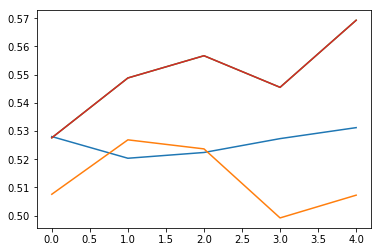

In [273]:
plt.plot([k[1] for k in model.predict(np.reshape(data[-5:], (5, 1, data.shape[1])))])
plt.show()